Epoch:0/40 Error_train:1.0929691538655446 Error_test:1.0923438215251675
Epoch:4/40 Error_train:0.7820261823911333 Error_test:0.7833906332815058
Epoch:8/40 Error_train:0.7806351647420783 Error_test:0.7826772099790116
Epoch:12/40 Error_train:0.78058520142514 Error_test:0.7828337194554126
Epoch:16/40 Error_train:0.7804274865889613 Error_test:0.7827621372471572
Epoch:20/40 Error_train:0.7803411549557699 Error_test:0.7828222185458582
Epoch:24/40 Error_train:0.7803853450312391 Error_test:0.7828946471056378
Epoch:28/40 Error_train:0.7802200670235991 Error_test:0.7827991640368138
Epoch:32/40 Error_train:0.7802826096746464 Error_test:0.7828346917339434
Epoch:36/40 Error_train:0.7801372308685768 Error_test:0.7827223753517386


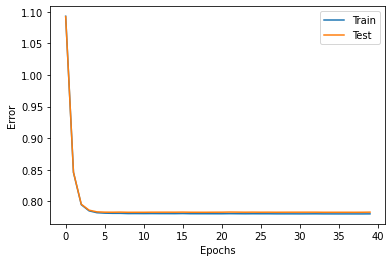

Accuracy Train: 71.81818181818181 % Accuracy Test: 71.81818181818181 %


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Wholesale dataset 가져오기
input_data = pd.read_csv("c:/test/w_data.csv")
correct = pd.read_csv("c:/test/w_target.csv")
n_data = len(correct)
input_data = input_data.to_numpy()
correct = correct.to_numpy()

# 입력 데이터 표준화
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

# 정답 데이터의 원-핫 인코딩
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# 훈련 데이터, 테스트 데이터 나누기
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

# 각 설정값
n_in = 6
n_mid = 18
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 500
batch_size = 10
interval = 50

# 클래스 정의
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
 
# 은닉층
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # 활성화 함수 : ReLu
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        self.grad_x = np.dot(delta, self.w.T)
        
# 드롭아웃층
class Dropout():
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio
    
    def forward(self, x, is_train):
        if is_train:
            rand = np.random.rand(*x.shape)
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = x * (1 - self.dropout_ratio)           
            
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout   
        
# 출력층
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.exp(self.u) / np.sum(np.exp(self.u), axis = 1, keepdims = True) # 활성화 함수 : SoftMax
    
    def backward(self,t):
        delta = self.y - t
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        self.grad_x = np.dot(delta, self.w.T)

# 각 층의 초기화
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

# 순전파
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout1.y)
    dropout2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout2.y)

# 역전파
def backpropagation(t):
    output_layer.backward(t)
    dropout2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout2.grad_x)
    dropout1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout1.grad_x)

# 가중치와 편향 수정
def update_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

# 교차 엔트로피 오차 계산    
def get_error(t, batch_size):
    return -np.sum(t*np.log(output_layer.y + 1e-7)) / batch_size

# 오차 기록용
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# 학습과 경과 기록
n_batch = n_train // batch_size
for i in range(epoch):
    # 오차 계속
    forward_propagation(input_train, False)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test, False)
    error_test = get_error(correct_test, n_test)
    
    # 오차 기록
    train_error_x.append(i)
    train_error_y.append(error_train)
    test_error_x.append(i)
    test_error_y.append(error_test)
    
    # 경과 표시
    if i % interval == 0:
        print('Epoch:' + str(i) + '/' + str(epoch),
             'Error_train:' + str(error_train),
              'Error_test:' + str(error_test))
    
    # 학습
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)
    for j in range(n_batch):
        # 미니 배치 샘플 추출
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 순전파와 역전파
        forward_propagation(x, True)
        backpropagation(t)
        
        # 가중치와 편향 수정
        update_wb()
        
# 기록된 오차를 그래프로 표시
plt.plot(train_error_x, train_error_y, label = 'Train')
plt.plot(test_error_x, test_error_y, label = 'Test')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Error')

plt.show()

# 정답률 측정
forward_propagation(input_train, False)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))
forward_propagation(input_test, False)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print('Accuracy Train:', str(count_train/n_train*100), '%',
     'Accuracy Test:', str(count_test/n_test*100), '%')